In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

import warnings
warnings.filterwarnings("ignore")

In [29]:
DATASET_DIRECTORY = ""

In [30]:
df = pd.read_csv(os.path.join(DATASET_DIRECTORY, "Job titles and industries.csv"))
df.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


In [31]:
df.shape

(8586, 2)

In [32]:
df.isnull().sum()

job title    0
industry     0
dtype: int64

In [33]:
df.duplicated().sum()/len(df)

0.5378523177265315

In [34]:
df["job title"].value_counts().sort_values(ascending=False)

marketing executive                                           91
php developer                                                 54
trainee network technician                                    53
software developer                                            53
marketing manager                                             49
                                                              ..
web services & sharepoint administrator                        1
teaching assistant  teaching personnel  full time  newham      1
marketing and creative manager - salary circa £50k - poole     1
early years sen graduate- hounslow                             1
communications and marketing manager                           1
Name: job title, Length: 3890, dtype: int64

In [35]:
df["industry"].value_counts()/len(df)

IT             0.552760
Marketing      0.236548
Education      0.167133
Accountancy    0.043559
Name: industry, dtype: float64

<AxesSubplot:xlabel='industry'>

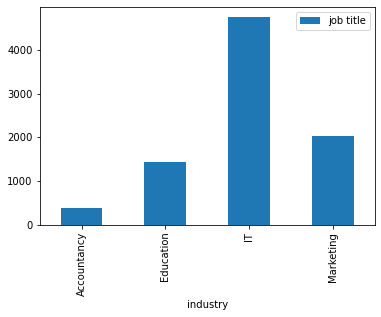

In [36]:
df_industry_group = df.groupby('industry').count()
df_industry_group.plot.bar()

In [37]:
#cleaned_df = df.drop_duplicates(subset="job title")
#cleaned_df["industry"].value_counts()/len(df)
cleaned_df = df

In [38]:
cleaned_df.shape

(8586, 2)

<AxesSubplot:xlabel='industry'>

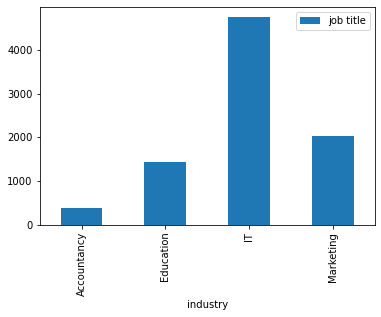

In [39]:
df_industry_group = cleaned_df.groupby('industry').count()
df_industry_group.plot.bar()

In [40]:
from gensim.parsing.preprocessing import STOPWORDS

def clean_text_stage_1(token):
    if token not in STOPWORDS and len(token) >= 3:
        return token.lower()
    return None

In [41]:
reversed_words = ["country", "london", "august", "jobs", "entry", "level"]

def clean_text_stage_2(token):
    if token in reversed_words:
        return None
    return token

In [42]:
def clean_text_stage_3(token):
    if token.isalpha():
        return token
    return None

In [43]:
from gensim.utils import simple_preprocess

def clean_title(title):
    result = ""
    for token in simple_preprocess(title):
        
        token = clean_text_stage_1(token)
        if token is None:
            continue
            
        token = clean_text_stage_2(token)
        if token is None:
            continue
            
        token = clean_text_stage_3(token)
        if token is None:
            continue
            
        result+=token+" "   
    return result.strip()

In [44]:
cleaned_df['job title'] = cleaned_df['job title'].apply(lambda title: clean_title(title))

In [45]:
cleaned_df.sample(10)

,job title,industry
8583,sales marketing manager,Marketing
5845,senior software developer,IT
604,head digital marketing ksa riyadh,IT
3964,helpdesk support engineer,IT
4384,senior content executive,Marketing
4074,scorecard senior consultant credit risk fraud,IT
6298,teacher mathematics,Education
1590,net developer software engineer postgresql,IT
2,head services,IT
4473,press officer,Marketing


In [46]:
from sklearn.model_selection import train_test_split

X = cleaned_df['job title']
y = cleaned_df['industry']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

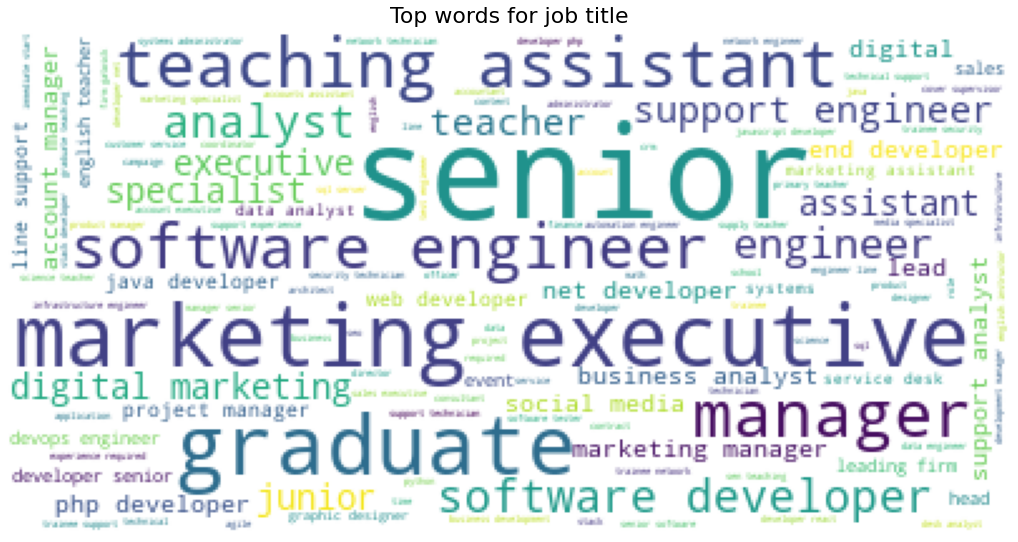

In [47]:
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white', 
    max_words=200
)
wc.generate(' '.join(text for text in X_train))
plt.figure(figsize=(18,10))
plt.title('Top words for job title', fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [48]:
from sklearn.preprocessing import LabelEncoder

endoded_class_path = "utils/model/encoded_class.npy"
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
np.save(endoded_class_path, encoder.classes_)

y_test = encoder.transform(y_test)

In [49]:
from sklearn.utils.class_weight import compute_class_weight

CLASSES_WEIGHT = compute_class_weight('balanced',np.unique(y_train),y_train)
CLASSES_WEIGHT = {k: v for k, v in enumerate(CLASSES_WEIGHT)}
CLASSES_WEIGHT

{0: 5.840136054421769,
 1: 1.5008741258741258,
 2: 0.450774481491205,
 3: 1.0592227020357803}

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

#count_vec = CountVectorizer()
#X_train = count_vec.fit_transform(X_train)
#X_test = count_vec.transform(X_test)

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer

#s = TfidfTransformer()
#X_train = tfidf_transformer.fit_transform(X_train)
#X_test = tfidf_transformer.transform(X_test)

In [52]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('count_vec', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
])

X_train = pipeline.fit_transform(X_train)
#pipeline.transform(X_test)

In [53]:
X_train.shape

(6868, 1634)

In [54]:
svm_transorm_pipleline_path = "utils/model/SVM_Transorm_Pipleline.joblib"

dump(pipeline, svm_transorm_pipleline_path)

['utils/model/SVM_Transorm_Pipleline.joblib']

In [55]:
pipeline = load(svm_transorm_pipleline_path)
X_test = pipeline.transform(X_test)

In [73]:
dict_model_perf = {}

In [89]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def print_model_performance(y_test, y_hat):
    
    print(classification_report(y_test, y_hat, target_names=encoder.classes_))
    print("Confusion Matrix")
    #print(confusion_matrix(y_test, y_hat, labels=list(encoder.classes_)))
    cm_array = confusion_matrix(y_test, y_hat)
    cm_array_df = pd.DataFrame(cm_array, index=encoder.classes_, columns=encoder.classes_)
    sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 
    plt.show()
    acc = accuracy_score(y_test, y_hat)
    print("Accuracy: ", acc)
    return acc

In [90]:
from sklearn.model_selection import GridSearchCV
    
def get_classifier_model_result(model, grid_params, X_train, y_train, X_test, y_test):
    clf = GridSearchCV(model, grid_params, cv = 10, scoring='accuracy')

    clf.fit(X_train, y_train)
    
    y_hat = clf.best_estimator_.predict(X_test)
    
    return clf.best_estimator_, print_model_performance(y_test, y_hat), y_hat

              precision    recall  f1-score   support

 Accountancy       0.91      0.84      0.87        80
   Education       0.96      0.93      0.95       291
          IT       0.96      0.96      0.96       937
   Marketing       0.90      0.93      0.92       410

    accuracy                           0.95      1718
   macro avg       0.93      0.92      0.92      1718
weighted avg       0.95      0.95      0.95      1718

Confusion Matrix


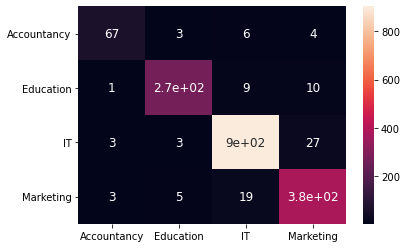

Accuracy:  0.9458672875436555


In [91]:
from sklearn.svm import SVC

model = SVC(class_weight=CLASSES_WEIGHT)

grid_params = [{"kernel":["rbf"], 
                "C":[0.9, 0.8, 0.7, 0.6, 0.5]}]

model, acc, y_hat = get_classifier_model_result(model, grid_params, X_train, y_train, X_test, y_test)
dict_model_perf["SVC"] = (acc, y_hat)

In [172]:
svm_model_path = "utils/model/SVM_Model.joblib"

dump(model, svm_model_path)

['utils/model/SVM_Model.joblib']

In [173]:
model = load(svm_model_path)
model.predict(X_test)

array([3, 3, 1, ..., 2, 3, 2], dtype=int64)

In [92]:
from sklearn.model_selection import train_test_split

X = cleaned_df["job title"]
y = cleaned_df["industry"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [93]:
from sklearn.preprocessing import LabelEncoder

endoded_class_path = "utils/model/encoded_class.npy"
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
np.save(endoded_class_path, encoder.classes_)

y_test = encoder.transform(y_test)

In [94]:
from sklearn.utils.class_weight import compute_class_weight

CLASSES_WEIGHT = compute_class_weight('balanced',np.unique(y_train),y_train)
CLASSES_WEIGHT = {k: v for k, v in enumerate(CLASSES_WEIGHT)}
CLASSES_WEIGHT

{0: 5.840136054421769,
 1: 1.5008741258741258,
 2: 0.450774481491205,
 3: 1.0592227020357803}

In [95]:
from keras.utils import np_utils

y_train_dummy = np_utils.to_categorical(y_train)
y_test_dummy = np_utils.to_categorical(y_test)

In [96]:
seq_len = X_train.apply(lambda x: len(x.split()))
MAX_SEQUENCE_LENGTH = np.max(seq_len)
MAX_SEQUENCE_LENGTH

11

In [97]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
#X_train = tokenizer.texts_to_sequences(X_train)
#X_test = tokenizer.texts_to_sequences(X_test)

In [98]:
MAX_NUM_WORDS = len(tokenizer.word_index) + 1
MAX_NUM_WORDS

1635

In [99]:
from keras.preprocessing.sequence import pad_sequences

#X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
#X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")

#print("Training X Shape:",X_train.shape)
#print("Testing X Shape:",X_test.shape)

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin
from keras.preprocessing.text import Tokenizer


class TokenizerTransformer(BaseEstimator, TransformerMixin, Tokenizer):

    def __init__(self, **tokenizer_params):
        Tokenizer.__init__(self, **tokenizer_params)

    def fit(self, X, y=None):
        self.fit_on_texts(X)
        return self

    def transform(self, X, y=None):
        X_transformed = self.texts_to_sequences(X)
        return X_transformed

In [101]:
from keras.preprocessing.sequence import pad_sequences


class PadSequencesTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, maxlen):
        self.maxlen = maxlen

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_padded = pad_sequences(X, maxlen=self.maxlen, padding="post")
        return X_padded

In [102]:
from sklearn.pipeline import Pipeline

tokenizer = TokenizerTransformer()
padder = PadSequencesTransformer(maxlen=MAX_SEQUENCE_LENGTH)

pipeline = Pipeline([
    ('tokenizer', tokenizer),
    ('pad_sequences', padder)])

X_train = pipeline.fit_transform(X_train) 
#pipeline.transform(X_test)

In [103]:
lstmdl_transorm_pipleline_path = "utils/model/LSTMDL_Transorm_Pipleline.joblib"

dump(pipeline, lstmdl_transorm_pipleline_path)

['utils/model/LSTMDL_Transorm_Pipleline.joblib']

In [104]:
pipeline = load(lstmdl_transorm_pipleline_path)
X_test = pipeline.transform(X_test)

In [105]:
n_classes = len(np.unique(y_train))
EMBEDDING_VECTOR_LENGHT = 64
n_classes

4

In [106]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D
from keras.layers.embeddings import Embedding


def create_model(optimizer="adam"):
    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_VECTOR_LENGHT, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.7))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [107]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 64)            104640    
_________________________________________________________________
conv1d (Conv1D)              (None, 7, 128)            41088     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 128)            131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8

In [108]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_file_path = "best_model.h5"

es = EarlyStopping(monitor="val_accuracy", patience=10, verbose=0, mode="max")
check_poiint = ModelCheckpoint(model_file_path, monitor="val_accuracy", verbose=0, save_best_only=True, save_weights_only=False, 
                               mode="max")

CALLBACKS = [es, check_poiint]

In [246]:
from sklearn.model_selection import GridSearchCV

EPOCHS = 100
BATCH_SIZE = 16

history = model.fit(X_train, y_train_dummy, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=1,
                    callbacks=CALLBACKS,
                    class_weight=CLASSES_WEIGHT,
                    validation_data=(X_test, y_test_dummy))

Epoch 1/100
430/430 [==============================] - 13s 31ms/step - loss: 0.5087 - accuracy: 0.5274 - val_loss: 0.3238 - val_accuracy: 0.6432
Epoch 2/100
430/430 [==============================] - 14s 32ms/step - loss: 0.3886 - accuracy: 0.6730 - val_loss: 0.2557 - val_accuracy: 0.7759
Epoch 3/100
430/430 [==============================] - 22s 50ms/step - loss: 0.2932 - accuracy: 0.8155 - val_loss: 0.1712 - val_accuracy: 0.8981
Epoch 4/100
430/430 [==============================] - 19s 45ms/step - loss: 0.2058 - accuracy: 0.8733 - val_loss: 0.1441 - val_accuracy: 0.9179
Epoch 5/100
430/430 [==============================] - 23s 54ms/step - loss: 0.1626 - accuracy: 0.9019 - val_loss: 0.1273 - val_accuracy: 0.9296
Epoch 6/100
430/430 [==============================] - 19s 45ms/step - loss: 0.1353 - accuracy: 0.9192 - val_loss: 0.1118 - val_accuracy: 0.9313
Epoch 7/100
430/430 [==============================] - 18s 43ms/step - loss: 0.1182 - accuracy: 0.9304 - val_loss: 0.1048 - val_ac

In [109]:
from keras.models import load_model, save_model

model = load_model(model_file_path)

In [110]:
y_hat = model.predict(X_test).argmax(axis=1)

              precision    recall  f1-score   support

 Accountancy       0.91      0.86      0.88        80
   Education       0.96      0.92      0.94       291
          IT       0.97      0.97      0.97       937
   Marketing       0.91      0.94      0.93       410

    accuracy                           0.95      1718
   macro avg       0.94      0.92      0.93      1718
weighted avg       0.95      0.95      0.95      1718

Confusion Matrix


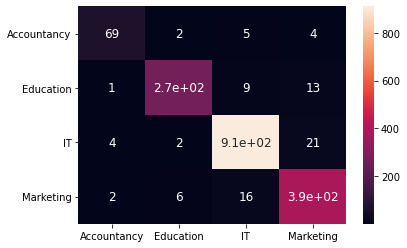

Accuracy:  0.9505238649592549


In [111]:
acc = print_model_performance(y_test, y_hat)
dict_model_perf["LSTMDL"] = acc

In [112]:
lstmdl_model_path = "utils/model/LSTMDL_Model.h5"

save_model(model, lstmdl_model_path)

In [113]:
model = load_model(lstmdl_model_path)
model.predict(X_test)

array([[1.4936854e-18, 4.6586242e-04, 3.2300949e-07, 9.9953389e-01],
       [1.9221064e-03, 3.3985376e-01, 2.9899828e-02, 6.2832427e-01],
       [5.9363242e-06, 7.8456438e-01, 7.9345674e-04, 2.1463625e-01],
       ...,
       [9.2927788e-10, 2.2290486e-03, 9.9772555e-01, 4.5402761e-05],
       [0.0000000e+00, 8.4635641e-12, 3.7196798e-21, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00]],
      dtype=float32)